# ML notebook
17.02.2025 -> 04.06.2025 - Dominique Humbert
Initial version.

Usefull links with which the Implementation was built:
- https://medium.com/coinmonks/learn-how-to-train-u-net-on-your-dataset-8e3f89fbd623

Model U-net from:
Vanberg, P.-O. (2019). Machine learning for image-based wavefront sensing. Université de Liège, Liège, Belgique.
https://explore.lib.uliege.be/permalink/32ULG_INST/oao96e/alma9919993582302321

In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
from ows import ows
from ows import fouriertransform as mathft
from astropy.io import fits
from astropy.visualization import SqrtStretch
import numpy as np
import time

In [ ]:
from PIL import Image

## Assemble dataset

Processing:  10 % done, time elapsed:  0.46423983573913574 s, remaining: ~ 4.131734538078308 s
Processing:  20 % done, time elapsed:  0.9476749897003174 s, remaining: ~ 3.7433162093162533 s
Processing:  30 % done, time elapsed:  1.3455884456634521 s, remaining: ~ 3.0948534250259394 s
Processing:  40 % done, time elapsed:  1.732337474822998 s, remaining: ~ 2.555197775363922 s
Processing:  50 % done, time elapsed:  2.1262404918670654 s, remaining: ~ 2.083715682029724 s
Processing:  60 % done, time elapsed:  2.5131125450134277 s, remaining: ~ 1.6335231542587278 s
Processing:  70 % done, time elapsed:  2.903474807739258 s, remaining: ~ 1.2028681346348353 s
Processing:  80 % done, time elapsed:  3.295590400695801 s, remaining: ~ 0.7827027201652523 s
Processing:  90 % done, time elapsed:  3.674968957901001 s, remaining: ~ 0.3674968957900999 s
Loading training set:  100 % done


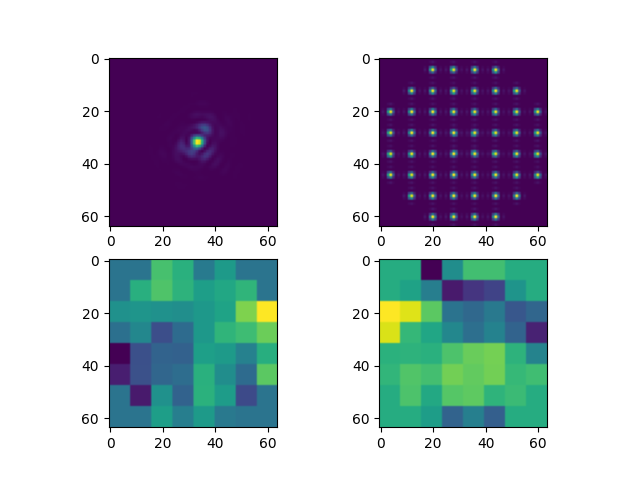

In [2]:
n = 99    # number of images sets available
dim_data = 64   # size of the images. (could be automated)

train_Dw = np.zeros((n,dim_data,dim_data,2))
train_lightfield = np.zeros((n,dim_data,dim_data))
train_psf = np.zeros((n,dim_data,dim_data))
train_ps = np.zeros((n,dim_data,dim_data))


filename0 = "data/DwDx_"
filename1 = "data/DwDy_"
filename2 = "data/lightfield_"
filename3 = "data/psf_"
filename4 = "data/ps_"


before = time.time()
status = 0
for i in range(0,n):
    train_Dw[i,:,:,0] = ows.pixel_adder(np.array(fits.getdata(filename0+str(i)+".fits")), scale_factor = [8,8], final_shape = None)/np.pi # Normalized by pi and scaled to dim_data pixels
    train_Dw[i,:,:,1] = ows.pixel_adder(np.array(fits.getdata(filename1+str(i)+".fits")), scale_factor = [8,8], final_shape = None)/np.pi # Normalized by pi and scaled to dim_data pixels

    train_lightfield[i,:,:] = np.array(fits.getdata(filename2+str(i)+".fits"))
    train_psf[i,:,:] = ows.normalize(np.array(fits.getdata(filename3+str(i)+".fits")))
    train_ps[i,:,:] = ows.normalize(np.array(fits.getdata(filename4+str(i)+".fits")))

    if 100*i//n == status*10:
        now = time.time()
        elapsed = now - before
        if status != 0:
            print('Processing: ',status*10,'% done, time elapsed: ',elapsed,'s, remaining: ~',((elapsed/(i/n))-elapsed),'s')
        status += 1

np.savez("data/train_Dw.npz", train_Dw)
np.savez("data/train_lightfield.npz", train_lightfield)
np.savez("data/train_psf.npz", train_psf)
np.savez("data/train_ps.npz", train_ps)

print('Loading training set: ',100,'% done')

plt.close()
plt.figure(1)
plt.subplot(2,2,1)
plt.imshow(train_psf[0,:,:])
plt.subplot(2,2,2)
plt.imshow(train_lightfield[0,:,:])
plt.subplot(2,2,3)
plt.imshow(train_Dw[0,:,:,0])
plt.subplot(2,2,4)
plt.imshow(train_Dw[0,:,:,1])

## Dataset already assemble

1. Random draw to separate the training and validation set
2. Split the datasets

In [ ]:
rng = np.random.default_rng(seed=None)
n = 1999

In [ ]:
# Training set
rng = np.random.default_rng(n)
temp = np.load("data/train_Dw.npz")["arr_0"]


n = temp.shape[0]
k = 0.8 
train_id = np.zeros(n,np.bool)

train_id[rng.choice(n,int(k*n),replace=False)] = True

print(temp.shape)
x_train = temp[train_id,:,:]
x_val = temp[~train_id,:,:]
# y_train = temp[train_id,:,:]
# y_val = temp[~train_id,:,:]


temp = np.load("data/train_psf.npz")["arr_0"]

y_train = temp[train_id,:,:]
y_val = temp[~train_id,:,:]
# x_train = temp[train_id,:,:]
# x_val = temp[~train_id,:,:]



plt.close(1)
plt.figure(1)
plt.imshow(x_train[4,:,:,0])
plt.show()

print(x_val.shape,x_train.shape)
print(y_val.shape,y_train.shape)


# Unet

In [ ]:
import ows.unet as unet
model = unet.build_unet(input_shape=(64,64,2), n_channels_out=1)
#model.summary()

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau 
weight_path="{}_weights.best.weights.h5".format('cxr_reg') 
 
checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1,  
                             save_best_only=True, mode='min', save_weights_only = True) 
 
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=3, 
                                   verbose=1, mode='min', epsilon=0.05, cooldown=2, min_lr=1e-6) 
 
early = EarlyStopping(monitor="val_loss",  mode="min", patience=15) # probably needs to be more patient, but kaggle time is limited 
callbacks_list = [checkpoint, early, reduceLROnPlat]

from IPython.display import clear_output 
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.optimizers import SGD 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import roc_curve, auc 
model.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9), loss=[unet.mse_loss], metrics = [unet.dice_coef, 'binary_accuracy',"AUC" ]) 
#images, mask = images/255, (mask>127).astype(np.float32) 
                                                            
train_vol = x_train

validation_vol = x_val
train_seg = y_train
validation_seg = y_val

print(train_seg.shape)

In [ ]:
loss_history = model.fit(x = train_vol,y = train_seg,batch_size = 12,epochs = 100,validation_data =(validation_vol,validation_seg) , callbacks=callbacks_list)


# Training results

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
ax1.plot(loss_history.history['loss'], '-', label = 'Loss')
ax1.plot(loss_history.history['val_loss'], '-', label = 'Validation Loss')
ax1.legend()

ax2.plot(100*np.array(loss_history.history['binary_accuracy']), '-', label = 'Accuracy')
ax2.plot(100*np.array(loss_history.history['val_binary_accuracy']), '-',label = 'Validation Accuracy')
ax2.legend()

# Inference

In [ ]:
DwDx = ows.pixel_adder(np.array(fits.getdata("data/DwDx_1999.fits")), scale_factor = [8,8], final_shape = None)
DwDy = ows.pixel_adder(np.array(fits.getdata("data/DwDy_1999.fits")), scale_factor = [8,8], final_shape = None)
psf = np.array(fits.getdata("data/psf_1999.fits"))
ps = np.array(fits.getdata("data/ps_1999.fits"))
Dw = (DwDx**2 + DwDx**2)**(1/2)
Dw = np.zeros((64,64,2))

Dw[:,:,0] = DwDx
Dw[:,:,1] = DwDy

im = np.expand_dims(Dw, axis=0)

predictions = model(im)
print(predictions.shape)


plt.close(2)
plt.figure(2)
plt.subplot(1,2,1)
plt.imshow(predictions[0,:,:])
plt.title("inference")
plt.subplot(1,2,2)
plt.imshow(psf[:,:])
plt.title("True image")
plt.show()
